<a href="https://colab.research.google.com/github/OpenXAIProject/PTAP/blob/main/PTAP_tutorial_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm

import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Flatten, Dropout, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

from sklearn.preprocessing import normalize

In [2]:
def readucr(filename):
    data = np.loadtxt(filename)
    Y = data[:,0]
    X = data[:,1:]
    return X, Y

## Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
path = '/content/drive/MyDrive/PTAP_Tutorial/data/'
x_train, y_train = readucr(path+'StarLightCurves_TRAIN.txt')
x_test, y_test = readucr(path+'StarLightCurves_TEST.txt')
nb_classes = len(np.unique(y_test))
batch_size = min(x_train.shape[0]/10, 16)

y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)

x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean)/(x_train_std)
x_test = (x_test - x_train_mean)/(x_train_std)

trainX = x_train[:, np.newaxis, :, np.newaxis]
testX = x_test[:, np.newaxis, :, np.newaxis]

trainY = np_utils.to_categorical(y_train, nb_classes)
testY = np_utils.to_categorical(y_test, nb_classes)

## Train Model

In [5]:
conv1_channel, conv2_channel, conv3_channel = 32, 64, 128

conv1_size, conv2_size, conv3_size = 15, 11, 7
conv1_pad, conv2_pad, conv3_pad = int((conv1_size -1) /2),int((conv2_size -1) /2),int((conv3_size -1) /2)
conv1_stride, conv2_stride, conv3_stride = 2, 1, 1

pool1_size, pool2_size, pool3_size = 8, 4, 4
pool1_pad, pool2_pad, pool3_pad = 0, 0, 0
pool1_stride, pool2_stride, pool3_stride = 4, 2, 2

In [6]:
model = Sequential()

## Layer 1
model.add(keras.layers.Conv2D(input_shape =(trainX.shape[1:]), 
                              filters=conv1_channel, kernel_size=conv1_size, strides=conv1_stride, padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size =pool1_size, strides=pool1_stride, padding='same', name='pool1'))
                          
## Layer 2          
model.add(keras.layers.Conv2D(filters=conv2_channel, kernel_size=conv2_size, strides=conv2_stride, padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size =pool2_size, strides=pool2_stride, padding='same', name='pool2'))
 
## Layer 3          
model.add(keras.layers.Conv2D(filters=conv3_channel, kernel_size=conv3_size, strides=conv3_stride, padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size =pool3_size, strides=pool3_stride, padding='same', name='pool3'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(nb_classes, activation='softmax'))

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
history = model.fit(trainX, trainY, batch_size = 128, epochs = 5, verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
8/8 [==============================] - 29s 1s/step - loss: 1.5738 - accuracy: 0.6044
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.2816 - accuracy: 0.8820
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.2734 - accuracy: 0.8589
Epoch 4/5
8/8 [==============================] - 10s 1s/step - loss: 0.2215 - accuracy: 0.9043
Epoch 5/5
8/8 [==============================] - 10s 1s/step - loss: 0.1950 - accuracy: 0.9268


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 512, 32)        7232      
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 512, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 1, 512, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 1, 128, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 128, 64)        247872    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 128, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 1, 128, 64)        0

# Extract TAP (Temporallly Activated Patterns) using receptive field 

### Calculate Receptive Field for Keras 

In [8]:
def nextlen(l, size, pad, stride):
    return int((l+2*pad-size+stride)/stride ) 

input_len = trainX.shape[2]
l1_conv_len = nextlen(input_len, conv1_size, conv1_pad, conv1_stride)
l1_pool_len = nextlen(l1_conv_len, pool1_size, pool1_pad, pool1_stride) +1
l2_conv_len = nextlen(l1_pool_len, conv2_size, conv2_pad, conv2_stride)
l2_pool_len = nextlen(l2_conv_len, pool2_size, pool2_pad, pool2_stride) +1
l3_conv_len = nextlen(l2_pool_len, conv3_size, conv3_pad, conv3_stride)
l3_pool_len = nextlen(l3_conv_len, pool3_size, pool3_pad, pool3_stride) +1
print(l1_conv_len,l1_pool_len,l2_conv_len,l2_pool_len,l3_conv_len,l3_pool_len)

512 128 128 64 64 32


In [9]:
Receptive_Field_index3 = []
for node in range(l3_pool_len):
    l3_conv_start = node*pool3_stride - pool3_pad
    l3_conv_end = node*pool3_stride - pool3_pad + pool3_size - 1
    l2_result_start = l3_conv_start*conv3_stride - conv3_pad
    l2_result_end = l3_conv_end*conv3_stride - conv3_pad + conv3_size -1    
    l2_conv_start = l2_result_start*pool3_stride - pool2_pad
    l2_conv_end = l2_result_end*pool2_stride - pool2_pad + pool2_size - 1
    l1_result_start = l2_conv_start*conv2_stride - conv2_pad
    l1_result_end = l2_conv_end*conv2_stride - conv2_pad + conv2_size -1
    l1_conv_start = l1_result_start*pool1_stride - pool1_pad
    l1_conv_end = l1_result_end*pool1_stride - pool1_pad + pool1_size - 1
    input_start = l1_conv_start*conv1_stride - conv1_pad
    input_end = l1_conv_end*conv1_stride - conv1_pad + conv1_size -1
    Receptive_Field_index3.append(np.arange(input_start,input_end+1))

### Load Intermediate layer

In [10]:
layer_name = 'pool3'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(trainX)

### Get Highly Activated Nodes

In [11]:
percent = 5  ### top 5%

### Get Highly 
threshold = np.percentile(intermediate_output,100-percent,[0,1,2])
threshold_bool = (intermediate_output > threshold).squeeze()     

pattern_length = np.max([len(x) for x in Receptive_Field_index3])

reindex_threshold_bool=[]
for data_idx in range(len(trainX)):
    for output_c in range(conv3_channel):
        if len([x for x in threshold_bool[data_idx,:,output_c].flatten() if x]):
            index = []
            for idx in [i for i,x in enumerate(threshold_bool[data_idx,:,output_c].flatten()) if x]:    
                reindex_threshold_bool.append([data_idx,output_c,idx])

### Save Pattern Information

In [12]:
pattern_idx_df = pd.DataFrame(reindex_threshold_bool,columns=["data_idx","output_channel","pattern_xs"])
groups = pattern_idx_df.groupby(["data_idx","pattern_xs"])#["output_channel"].apply(list)
pattern_repetitive_idx_df = groups["output_channel"].apply(list).reset_index(name='output_channel')

In [13]:
TAP=[]
pattern_id=0

data_idx = pattern_repetitive_idx_df.loc[:,"data_idx"].values.tolist()
output_channel = pattern_repetitive_idx_df.loc[:,"output_channel"].values.tolist()
pattern_xs = pattern_repetitive_idx_df.loc[:,"pattern_xs"].values.tolist()

for d_idx, output_c, p_xs in zip(data_idx, output_channel, pattern_xs):
    for input_c in range(trainX.shape[3]):
        if (Receptive_Field_index3[p_xs][0] >= 0) and (Receptive_Field_index3[p_xs][-1] < trainX.shape[2]) :
            pattern_dict={}
            pattern_dict["pattern_id"]= pattern_id
            pattern_dict["data_idx"] = d_idx
            pattern_dict["output_channel"] = output_c
            pattern_dict["input_channel"] = input_c
            pattern_dict["pattern_xs"]= Receptive_Field_index3[p_xs]
            pattern_dict["pattern_ys"] = trainX[d_idx, 0, Receptive_Field_index3[p_xs], input_c]
            pattern_dict["features"] = intermediate_output[d_idx, 0, p_xs, :]
            pattern_dict["activations"] = threshold_bool[d_idx, p_xs, :]

            TAP.append(pattern_dict)
            pattern_id += 1

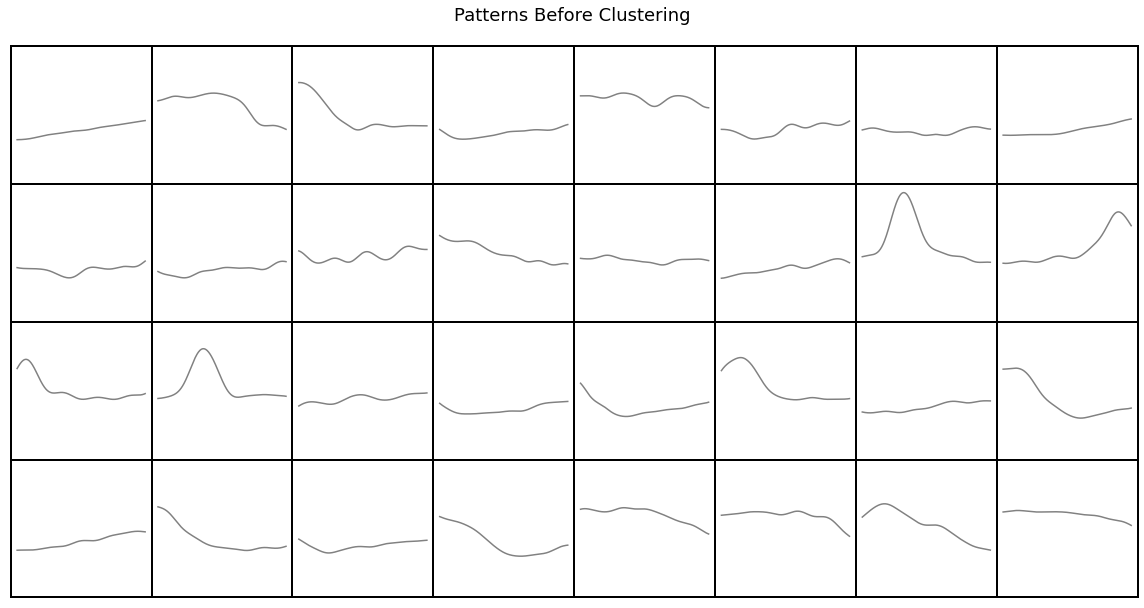

In [19]:
subsequences = np.array([x['pattern_ys'] for x in TAP])
display_n= 32

column = 8
row = int((display_n-1)/column)+1


fig = plt.figure(figsize=(16,row*2))
gs = gridspec.GridSpec(row,column)
gs.update(wspace=0, hspace=0)

samples = np.random.choice(len(subsequences), display_n, replace=False)

for i, n in enumerate(samples):
    ax = plt.subplot(gs[i])
    ax.plot(subsequences[n], color='black',alpha=2.5)
    ax.set_ylim(-5,5)
    
    ax.set_xticks([])
    ax.set_yticks([])
    plt.setp(ax.spines.values(), linewidth=2)
plt.suptitle("Patterns Before Clustering", y=1.05, fontsize=18)
plt.tight_layout()
plt.show()

# Select Prototype

In [20]:
def select_greedy_protos(K, m):

    ''' selected: an array of selected prototypes '''
    ''' obj_list: a list of the objective values '''

    n = np.shape(K)[0]
    selected = np.array([], dtype=int)
    obj_list = []
    nsk = 0

    colsum = 2/n*np.sum(K, axis=0)

    for i in range(m):
        argmax = -1
        candidates = np.setdiff1d(range(n), selected)
        vec1 = colsum[candidates]
        lenS = len(selected)

        if lenS > 0:
            temp = K[selected, :][:, candidates]
            vec2 = np.sum(temp, axis=0) *2 + np.diagonal(K)[candidates]
            vec2 = vec2/(lenS + 1)
            vec3 = vec1 - vec2
        else:
            vec3 = vec1 - (np.abs(np.diagonal(K)[candidates]))

        ''' vec3: {J(selected U {new})-J(selected)}*(lenS + 1) '''
        ''' increase of the objective value'''
        max_idx = np.argmax(vec3)

        if lenS > 0:
            ''' j: J(selected U {new})'''
            sk = np.sum(K[selected, :][:, selected])
            j = vec3[max_idx]/(lenS+1) - nsk/(lenS*(lenS+1)) + (1/(lenS**2)-1/((lenS+1)**2))*sk
            obj_list.append(j)
        else:
            obj_list.append(vec3[max_idx])

        argmax = candidates[max_idx]
        selected = np.append(selected, argmax)

        ''' nsk: (2/n)*\sum{k([n],S)} '''
        nsk += vec1[max_idx]

    return selected, obj_list

In [21]:
data_indices = np.array([x['data_idx'] for x in TAP])
subsequences = np.array([x['pattern_ys'] for x in TAP])
features = np.array([x['features'] for x in TAP])

** You need enough CPU memory for here. Some datasets require more than 1TB CPU memory. 

In [22]:
%%time

powers = 20
pat = np.array(features)
pat = pat/(np.linalg.norm(pat, axis=1).reshape(-1,1))
pat = normalize(pat, norm='l2')

gram_kernel = np.power(np.inner(pat, pat), powers)

CPU times: user 6.59 s, sys: 857 ms, total: 7.45 s
Wall time: 6.73 s


In [23]:
# Gram kernel
m= 8  ## the number of prototype
selected, obj_list= select_greedy_protos(gram_kernel, m)

### Visualzation of all prototypes

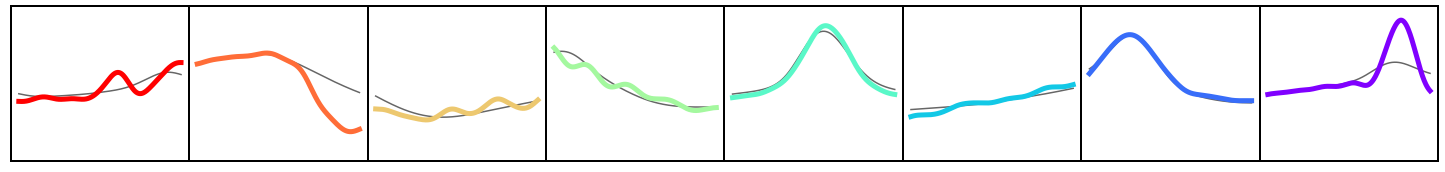

In [24]:
color = cm.rainbow(np.linspace(0,1,m))[::-1]
classified = np.argmax(gram_kernel[:, selected[:m]], axis=1)
yrange=(-3.5,3.5)
protos = subsequences[selected[:m]]

row = int((m-1)/16)+1
column = 16
# fig = plt.figure(figsize=(25,3*row))
fig = plt.figure(figsize=(40,row*2.5))
gs = gridspec.GridSpec(row,column)
gs.update(wspace=0, hspace=0)

for n in range(m):
    group_idx = [i for i,x in enumerate(classified) if x == n]
    members = subsequences[classified==n]
    proto_std = members.std(axis=0)
    proto_mean = members.mean(axis=0)
    ax = plt.subplot(gs[n])
                     
    ax.plot(proto_mean, color='black',alpha=0.6)
    ax.plot(protos[n], color =color[n],alpha=1,linewidth=5)

    ax.set_ylim(yrange)
    
    ax.set_xticks([])
    ax.set_yticks([])
    plt.setp(ax.spines.values(), linewidth=2)
    
plt.tight_layout()
plt.show()


### Visualzation of a specific prototype

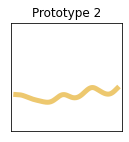

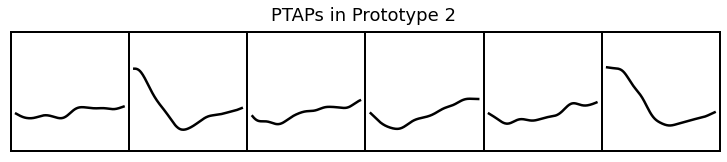

In [25]:
proto_idx = 2
display_n = 6

group_idx = [i for i,x in enumerate(classified) if x == proto_idx]
members = subsequences[classified==proto_idx]
proto_std = members.std(axis=0)
proto_mean = members.mean(axis=0)

plt.figure(figsize=(2,2))
plt.plot(protos[proto_idx], color =color[proto_idx],alpha=1,linewidth=5)
plt.ylim(-3.5,3.5)
plt.xticks([])
plt.yticks([])
plt.title("Prototype {}".format(proto_idx))
plt.show()

fig = plt.figure(figsize=(1.7*display_n, 2))
gs = gridspec.GridSpec(1,display_n)
gs.update(wspace=0, hspace=0)

indices =  np.random.choice(len(members), display_n, replace=False)
for t, member in enumerate(members[indices]):
    ax = plt.subplot(gs[t])
    ax.plot(member, linewidth=2.5, color='black')

    ax.set_ylim(yrange)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.setp(ax.spines.values(), linewidth=2)
    
plt.suptitle("PTAPs in Prototype {}".format(proto_idx), y=1.1, fontsize=18)
plt.tight_layout()
plt.show()

### Visualzation with input

In [26]:
data_indices = np.array([x['data_idx'] for x in TAP])
subsequences = np.array([x['pattern_ys'] for x in TAP])
subseq_x = np.array([x['pattern_xs'] for x in TAP])
features = np.array([x['features'] for x in TAP])

### Random Choose Patterns & Romove Overap

(-3.0, 3.0)

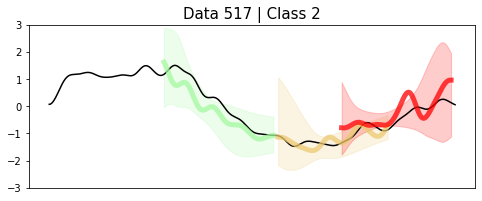

In [32]:
tar_class = 2
tar_set = np.where(np.argmax(trainY, axis=1)==tar_class)[0]

idx = np.random.choice(tar_set, 1)[0]

pattern_list = np.where(data_indices==idx)[0]
pattern_list = pattern_list[np.argsort(-np.max(gram_kernel[pattern_list, :], axis=1))]

pattern_list2 = []
for i, p in enumerate(pattern_list):
    if i==0:
        pattern_list2.append(p)
    else:
        add = True
        for p2 in pattern_list2:
            if np.abs(subseq_x[p][0] - subseq_x[p2][0])<150:
                add = False
                break
        if add:
            pattern_list2.append(p)

fig = plt.figure(figsize=(8,3))

plt.title("Data {} | Class {}".format(idx, tar_class),fontsize=15)
plt.plot(trainX[idx].squeeze(), c='black')

# p_idx = pattern_list[0]
corres_p_list = []
for i, p_idx in  enumerate(pattern_list2):
    proto_idx = classified[p_idx]
    corres_p_list.append(proto_idx)
    
    members = subsequences[classified==proto_idx]
    proto_std = members.std(axis=0)*1.5
    proto_mean = members.mean(axis=0)
    
    plt.fill_between(subseq_x[p_idx, :], proto_mean-proto_std, proto_mean+proto_std, color=color[proto_idx], alpha=0.2)
    plt.plot(subseq_x[p_idx, :], protos[proto_idx], c=color[proto_idx], linewidth=5, alpha=0.75)

plt.xticks([])
plt.ylim(-3,3)